Import Required Library

In [80]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

Reading Data

In [81]:
df=pd.read_csv("output.csv")

In [82]:
df

,Subject ID,MRI ID,Group,Visit,MR Delay,Sex,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,0,1,0,1,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,0,2,457,1,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,1,1,0,1,R,75,12,4.0,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,1,2,560,1,R,76,12,4.0,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,1,3,1895,1,R,80,12,4.0,22.0,0.5,1698,0.701,1.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,OAS2_0185,OAS2_0185_MR2,1,2,842,1,R,82,16,1.0,28.0,0.5,1693,0.694,1.037
369,OAS2_0185,OAS2_0185_MR3,1,3,2297,1,R,86,16,1.0,26.0,0.5,1688,0.675,1.040
370,OAS2_0186,OAS2_0186_MR1,0,1,0,0,R,61,13,2.0,30.0,0.0,1319,0.801,1.331
371,OAS2_0186,OAS2_0186_MR2,0,2,763,0,R,63,13,2.0,30.0,0.0,1327,0.796,1.323


Cut only firsts and seconds and third visits

In [83]:
df_copy = df.copy()
has_third_subject_id = df[df["Visit"] == 3]["Subject ID"].values
df = df[df['Subject ID'].isin(has_third_subject_id)]
df = df[df["Visit"] < 4]
df.reset_index(drop = True, inplace = True)
df = pd.get_dummies(df, columns = ["Visit"],prefix = "Visit")

Extract Subject_id and Group of Visist_3

In [84]:
visit_3 = df[df["Visit_3"] == 1][["Subject ID","Group"]]

In [85]:
df

,Subject ID,MRI ID,Group,MR Delay,Sex,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Visit_1,Visit_2,Visit_3
0,OAS2_0002,OAS2_0002_MR1,1,0,1,R,75,12,4.0,23.0,0.5,1678,0.736,1.046,True,False,False
1,OAS2_0002,OAS2_0002_MR2,1,560,1,R,76,12,4.0,28.0,0.5,1738,0.713,1.010,False,True,False
2,OAS2_0002,OAS2_0002_MR3,1,1895,1,R,80,12,4.0,22.0,0.5,1698,0.701,1.034,False,False,True
3,OAS2_0005,OAS2_0005_MR1,0,0,1,R,80,12,4.0,28.0,0.0,1689,0.712,1.039,True,False,False
4,OAS2_0005,OAS2_0005_MR2,0,1010,1,R,83,12,4.0,29.0,0.5,1701,0.711,1.032,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,OAS2_0185,OAS2_0185_MR2,1,842,1,R,82,16,1.0,28.0,0.5,1693,0.694,1.037,False,True,False
164,OAS2_0185,OAS2_0185_MR3,1,2297,1,R,86,16,1.0,26.0,0.5,1688,0.675,1.040,False,False,True
165,OAS2_0186,OAS2_0186_MR1,0,0,0,R,61,13,2.0,30.0,0.0,1319,0.801,1.331,True,False,False
166,OAS2_0186,OAS2_0186_MR2,0,763,0,R,63,13,2.0,30.0,0.0,1327,0.796,1.323,False,True,False


Value of Each Visit' Group is realized through the fulfillment of visit value

In [86]:
for i in range(1, 4):  # For Visit_1 to Visit_3
    visit_column = f"Visit_{i}"
    group_column = "Group"
    df[visit_column] = np.where(df[visit_column], df[group_column], 0)

print(df)

    Subject ID         MRI ID  Group  MR Delay  Sex Hand  Age  EDUC  SES   
0    OAS2_0002  OAS2_0002_MR1      1         0    1    R   75    12  4.0  \
1    OAS2_0002  OAS2_0002_MR2      1       560    1    R   76    12  4.0   
2    OAS2_0002  OAS2_0002_MR3      1      1895    1    R   80    12  4.0   
3    OAS2_0005  OAS2_0005_MR1      0         0    1    R   80    12  4.0   
4    OAS2_0005  OAS2_0005_MR2      0      1010    1    R   83    12  4.0   
..         ...            ...    ...       ...  ...  ...  ...   ...  ...   
163  OAS2_0185  OAS2_0185_MR2      1       842    1    R   82    16  1.0   
164  OAS2_0185  OAS2_0185_MR3      1      2297    1    R   86    16  1.0   
165  OAS2_0186  OAS2_0186_MR1      0         0    0    R   61    13  2.0   
166  OAS2_0186  OAS2_0186_MR2      0       763    0    R   63    13  2.0   
167  OAS2_0186  OAS2_0186_MR3      0      1608    0    R   65    13  2.0   

     MMSE  CDR  eTIV   nWBV    ASF  Visit_1  Visit_2  Visit_3  
0    23.0  0.5  1678  0

In [87]:
df

,Subject ID,MRI ID,Group,MR Delay,Sex,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Visit_1,Visit_2,Visit_3
0,OAS2_0002,OAS2_0002_MR1,1,0,1,R,75,12,4.0,23.0,0.5,1678,0.736,1.046,1,0,0
1,OAS2_0002,OAS2_0002_MR2,1,560,1,R,76,12,4.0,28.0,0.5,1738,0.713,1.010,0,1,0
2,OAS2_0002,OAS2_0002_MR3,1,1895,1,R,80,12,4.0,22.0,0.5,1698,0.701,1.034,0,0,1
3,OAS2_0005,OAS2_0005_MR1,0,0,1,R,80,12,4.0,28.0,0.0,1689,0.712,1.039,0,0,0
4,OAS2_0005,OAS2_0005_MR2,0,1010,1,R,83,12,4.0,29.0,0.5,1701,0.711,1.032,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,OAS2_0185,OAS2_0185_MR2,1,842,1,R,82,16,1.0,28.0,0.5,1693,0.694,1.037,0,1,0
164,OAS2_0185,OAS2_0185_MR3,1,2297,1,R,86,16,1.0,26.0,0.5,1688,0.675,1.040,0,0,1
165,OAS2_0186,OAS2_0186_MR1,0,0,0,R,61,13,2.0,30.0,0.0,1319,0.801,1.331,0,0,0
166,OAS2_0186,OAS2_0186_MR2,0,763,0,R,63,13,2.0,30.0,0.0,1327,0.796,1.323,0,0,0


Split Data 

In [88]:
RANDOM_STATE = 13
splitter = GroupShuffleSplit(test_size=.20, n_splits=1,
random_state = RANDOM_STATE)
split = splitter.split(df, groups=df['Subject ID'])
train_indexes, test_indexes = next(split)
X_train = df.iloc[train_indexes]
X_test = df.iloc[test_indexes]

Normaliation 

In [89]:
#Normalization
delay_scaler = MinMaxScaler()
age_scaler = MinMaxScaler()
educ_scaler = MinMaxScaler()
mmse_scaler = MinMaxScaler()
etiv_scaler = MinMaxScaler()
delay_scaler.fit(X_train["MR Delay"].to_numpy().reshape(-1,1))
age_scaler.fit(X_train["Age"].to_numpy().reshape(-1,1))
educ_scaler.fit(X_train["EDUC"].to_numpy().reshape(-1,1))
mmse_scaler.fit(X_train["MMSE"].to_numpy().reshape(-1,1))
etiv_scaler.fit(X_train["eTIV"].to_numpy().reshape(-1,1))
X_train["MR Delay"] = delay_scaler.transform(X_train["MR Delay"].to_numpy().reshape(-1,1))
X_train["Age"] = age_scaler.transform(X_train["Age"].to_numpy().reshape(-1,1))
X_train["EDUC"] = educ_scaler.transform(X_train["EDUC"].to_numpy().reshape(-1,1))
X_train["MMSE"] = mmse_scaler.transform(X_train["MMSE"].to_numpy().reshape(-1,1))
X_train["eTIV"] = etiv_scaler.transform(X_train["eTIV"].to_numpy().reshape(-1,1))
X_test["MR Delay"] = delay_scaler.transform(X_test["MR Delay"].to_numpy().reshape(-1,1))
X_test["Age"] = age_scaler.transform(X_test["Age"].to_numpy().reshape(-1,1))
X_test["EDUC"] = educ_scaler.transform(X_test["EDUC"].to_numpy().reshape(-1,1))
X_test["MMSE"] = mmse_scaler.transform(X_test["MMSE"].to_numpy().reshape(-1,1))
X_test["eTIV"] = etiv_scaler.transform(X_test["eTIV"].to_numpy().reshape(-1,1))

C:\Users\HP\AppData\Local\Temp\ipykernel_8964\4239079178.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["MR Delay"] = delay_scaler.transform(X_train["MR Delay"].to_numpy().reshape(-1,1))
C:\Users\HP\AppData\Local\Temp\ipykernel_8964\4239079178.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["Age"] = age_scaler.transform(X_train["Age"].to_numpy().reshape(-1,1))
C:\Users\HP\AppData\Local\Temp\ipykernel_8964\4239079178.py:14: SettingWithCopyWarning: 
A value is trying to be set on a 

Train Test Final

In [90]:
y_train_final = []
for id in X_train["Subject ID"].unique():
    res = visit_3[visit_3["Subject ID"] == id]["Group"].values[0]
    y_train_final.append(res)
y_test_final = []
for id in X_test["Subject ID"].unique():
    res = visit_3[visit_3["Subject ID"] == id]["Group"].values[0]
    y_test_final.append(res)
y_train_super_final = pd.DataFrame({
"Group": y_train_final})
y_test_super_final = pd.DataFrame({
"Group": y_test_final})
X_test_final = X_test.drop(["MRI ID","Hand"], axis = 1)
X_train_final = X_train.drop(["MRI ID","Hand"], axis = 1)


In [91]:
X_train_final

,Subject ID,Group,MR Delay,Sex,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Visit_1,Visit_2,Visit_3
3,OAS2_0005,0,0.000000,1,0.540541,0.352941,4.0,0.866667,0.0,0.764977,0.712,1.039,0,0,0
4,OAS2_0005,0,0.439704,1,0.621622,0.352941,4.0,0.933333,0.5,0.783410,0.711,1.032,0,0,0
5,OAS2_0005,0,0.697867,1,0.675676,0.352941,4.0,1.000000,0.0,0.780338,0.705,1.033,0,0,0
6,OAS2_0007,1,0.000000,1,0.297297,0.588235,2.0,0.866667,0.5,0.254992,0.748,1.293,1,0,0
7,OAS2_0007,1,0.225512,1,0.351351,0.588235,2.0,0.800000,1.0,0.267281,0.727,1.286,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,OAS2_0185,1,0.366565,1,0.594595,0.588235,1.0,0.866667,0.5,0.771121,0.694,1.037,0,1,0
164,OAS2_0185,1,1.000000,1,0.702703,0.588235,1.0,0.733333,0.5,0.763441,0.675,1.040,0,0,1
165,OAS2_0186,0,0.000000,0,0.027027,0.411765,2.0,1.000000,0.0,0.196621,0.801,1.331,0,0,0
166,OAS2_0186,0,0.332172,0,0.081081,0.411765,2.0,1.000000,0.0,0.208909,0.796,1.323,0,0,0


Fit the mixed-effects logistic regression model


In [92]:
formula = 'Visit_3 ~ Age + EDUC + CDR + eTIV + nWBV + ASF + Visit_1+Visit_2'
model = sm.MixedLM.from_formula(formula, data=X_train_final, groups=X_train_final['Subject ID'])


In [93]:
result = model.fit()

Predict the Group at Visit 3 using the fixed predictors for Visit 1 and Visit 2

In [94]:
predicted_probs = result.predict(exog=X_test_final)

Convert the probabilities to binary (0 or 1) based on a threshold ( 0.5)

In [95]:
threshold = 0.5
predicted_groups = (predicted_probs >= threshold).astype(int)
len(predicted_groups)

36

Predict the Group at Visit 3 using the fixed predictors for Visit 1 and Visit 2


In [96]:
predicted_probs = result.predict(exog=X_test_final)

Convert the probabilities to binary (0 or 1) based on a threshold (e.g., 0.5)

In [97]:
threshold = 0.5
predicted_groups = (predicted_probs >= threshold).astype(int)

Get the actual Group values at Visit 3

In [98]:
actual_groups = y_test_super_final

Evaluate the model

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

Non-Demented       0.50      1.00      0.67         6
    Demented       0.00      0.00      0.00         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

Confusion Matrix:
[[6 0]
 [6 0]]


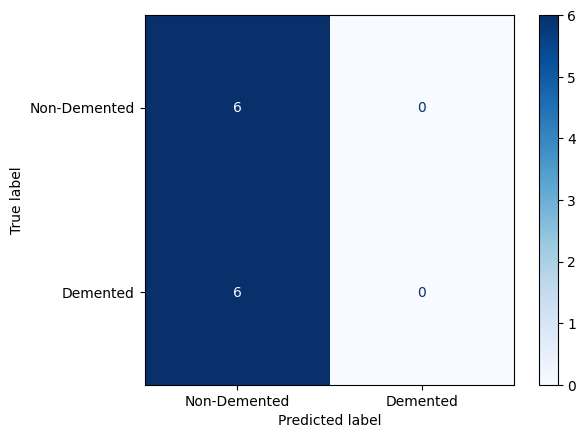

In [99]:
print(classification_report(actual_groups, predicted_groups[0:12], target_names=["Non-Demented", "Demented"]))
# Compute the confusion matrix
conf_matrix = confusion_matrix(actual_groups, predicted_groups[0:12])
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Demented", "Demented"])
confusion_matrix_display.plot(cmap='Blues', values_format='d')
plt.show()  # Display the confusion matrix plot

In [102]:
TP=conf_matrix[1,1]
FP=conf_matrix[0,1]
TN=conf_matrix[0,0]
FN=conf_matrix[1,0]
accuracy2=(TP+TN)/(TP+FP+FN+TN)
recall2=TP/(TP+FN)
percision2=TP/(TP+TN)
print(round(accuracy2,2),round(recall2,2),round(percision2,2))

0.5 0.0 0.0
